<a href="https://www.kaggle.com/code/duynhatvo/clashroyale?scriptVersionId=93721569" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Clash Royale Dataset Analysis

## 1. Introduction

In this notebook, we are going to analyze the [Clash Royale Dataset](https://www.kaggle.com/datasets/nonrice/clash-royale-battles-upper-ladder-december-2021). This dataset documents over 700 thousands matches of the mobile game [Clash Royale](https://clashroyale.com/) by Supercell. We will first brief through the basic mechanics of the games and the goal of this project, then the analysis and conclusion part.

## 2. Objectives:
### a. Clash Royale:
Clash Royale is a realtime strategy mobile game, where 2 players fight over a 3-minute match to destroy their opponent's towers. Each player will have a prechosen deck consisting of 8 cards, and will continuously deploy their cards which are either minions or spells. The game ends after 3 minutes, or if a player's main tower is destroyed.

As simple as it may sound, analyzing who would win a match is very difficult, due to the huge permutations of cards (there are 106 cards in total), as well as the different players' skills. In this notebook, we are going to analyze the dataset with the following assumptions:
- The matches happen in a small time span (December 2021), and no update (tweaks to each card's stats) are done.
- The matches happen between the top-ranked players in the world, and they all have very similar skills.

### b. Our approach:
In this notebook, we are going to try and see whether we can predict an outcome of a match using the decks and the rank of each player.

In [31]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import os
import json
# import csv

In [5]:
battles = pd.read_csv('data-cp/battles.csv')
battles[['p1_tag', 'p1_trophy', 'p2_tag', 'p2_trophy',
               'p1_crowns', 'p2_crowns', 'winner']]

,p1_tag,p1_trophy,p2_tag,p2_trophy,p1_crowns,p2_crowns,winner
0,#C9P0L2C0Q,3071,#ULU9G9QRC,3047,0,1,2
1,#C9P0L2C0Q,3101,#C9QQ2VRGL,3100,0,3,2
2,#U8JJV8L0Q,3000,#C8G22U2VV,3019,0,3,2
3,#U8JJV8L0Q,3000,#ULU9G9QRC,3019,0,2,2
4,#U8JJV8L0Q,3000,#JGJ2L89J0,3014,0,3,2
...,...,...,...,...,...,...,...
39343,#UQP8Y8LJP,2474,#CV808QV0R,2480,3,1,1
39344,#UQP8Y8LJP,2442,#UUG808QCR,2473,2,1,1
39345,#UQP8Y8LJP,2413,#UC2Y8899J,2408,2,1,1
39346,#UQP8Y8LJP,2383,#CVJ8V9VG0,2385,2,1,1


In [6]:
print("Total number of Columns:", battles.shape[1])
print("Total number of Rows:", battles.shape[0])
print("")
print("Column Names:", list(battles.columns))

Total number of Columns: 40
Total number of Rows: 39348

Column Names: ['Unnamed: 0', 'p1_tag', 'p1_trophy', 'p1_card_0_id', 'p1_card_0_lv', 'p1_card_1_id', 'p1_card_1_lv', 'p1_card_2_id', 'p1_card_2_lv', 'p1_card_3_id', 'p1_card_3_lv', 'p1_card_4_id', 'p1_card_4_lv', 'p1_card_5_id', 'p1_card_5_lv', 'p1_card_6_id', 'p1_card_6_lv', 'p1_card_7_id', 'p1_card_7_lv', 'p1_crowns', 'p2_tag', 'p2_trophy', 'p2_card_0_id', 'p2_card_0_lv', 'p2_card_1_id', 'p2_card_1_lv', 'p2_card_2_id', 'p2_card_2_lv', 'p2_card_3_id', 'p2_card_3_lv', 'p2_card_4_id', 'p2_card_4_lv', 'p2_card_5_id', 'p2_card_5_lv', 'p2_card_6_id', 'p2_card_6_lv', 'p2_card_7_id', 'p2_card_7_lv', 'p2_crowns', 'winner']


As can be seen above, we have collected 1426 unique vectors of datapoints with 40 columns each that provide us with relevant information on their respective battle. 19 columns are divided each between the two players where 16 columns are for the cards with 8 each for the unique card ID and its corresponding level and out of the 3 remaining columns, 1 each for ID, trophies, and crowns. Essentially, the column names represent:
- `p_tag`: Unique ID of the player
- `p_trophy`: The trophies of the player (can be thought of as ranking)
- `p_crowns`: The number of towers destroyed of by the player in the battle (max 3 == win)
- `p_card_x_id`: The unique card ID of card `x`
- `p_card_x_level`: The level of the corresponding card `x`
- `p_winner`: The player who won the game

The unique card ID's have specific data points as described in the cell below where cards data is analyzed.


In [7]:
cards = pd.read_csv('data-cp/cards.csv')
cards[['key', 'id', 'elixir', 'type', 'rarity']][:5]

,key,id,elixir,type,rarity
0,knight,26000000,3,Troop,Common
1,archers,26000001,3,Troop,Common
2,goblins,26000002,2,Troop,Common
3,giant,26000003,5,Troop,Rare
4,pekka,26000004,7,Troop,Epic


In [8]:
print("Number of Columns:", cards.shape[1])
print("Number of Rows:", cards.shape[0])
print("")
print("Column Names:", list(cards.columns))
print("")
print("Types of cards:", sorted(cards['type'].unique()))
print("Rarity of cards:", sorted(cards['rarity'].unique()))
print("Elixir for cards:", sorted(cards['elixir'].unique()))

Number of Columns: 11
Number of Rows: 107

Column Names: ['key', 'name', 'sc_key', 'elixir', 'type', 'rarity', 'id', 'flying_height', 'range', 'damage_air', 'damage_ground']

Types of cards: ['Building', 'Spell', 'Troop']
Rarity of cards: ['Champion', 'Common', 'Epic', 'Legendary', 'Rare']
Elixir for cards: [1, 2, 3, 4, 5, 6, 7, 8, 9]


We observe that there are 3 card types (Building, Spell, and Troop), 5 rarities (Common, Rare, Epic, Legendary, Champion), and the elixir ranging from 1 to 9.

Now, we create arrays for the player 1 and player 2 cards, which will be useful for later analysis.

In [9]:
p1_cols = []
p2_cols = []
for col_name in battles.columns:
    if 'p1_card_' in col_name and '_id' in col_name:
        p1_cols.append(col_name)
    elif 'p2_card_' in col_name and '_id' in col_name:
        p2_cols.append(col_name)
        
p1_cards = battles[p1_cols]
p2_cards = battles[p2_cols]
print("Player1 Column Names:", list(p1_cards.columns))
print("PLayer2 Column Names:", list(p2_cards.columns))
print("Total number of Rows:", len(list(p1_cards.index)))

Player1 Column Names: ['p1_card_0_id', 'p1_card_1_id', 'p1_card_2_id', 'p1_card_3_id', 'p1_card_4_id', 'p1_card_5_id', 'p1_card_6_id', 'p1_card_7_id']
PLayer2 Column Names: ['p2_card_0_id', 'p2_card_1_id', 'p2_card_2_id', 'p2_card_3_id', 'p2_card_4_id', 'p2_card_5_id', 'p2_card_6_id', 'p2_card_7_id']
Total number of Rows: 39348


In [12]:
# create map for card ID and row
id_map = {}
for row in cards.index:
    id_map[cards.loc[row, 'id']] = row

## 3. Some classic algorithms:

In the following cells we do the following:
1. We first encode each players' deck into $1 \times 107$ vectors, where $V_i = 1$ if the $i^{th}$ card is in the deck, $0$ otherwise. This seems to be a better choice than one-hot encoding, as there are $\begin{pmatrix}107 \\ 8 \end{pmatrix} \approx 3 \times 10^{11}$ possible choices of decks.
2. We then split the whole data set into training sets and test sets for supervised classification. We also keep a list of all decks choice people used to see if unsupervised learning give us some better insights into the data set.
3. We then apply some well-known simple Classification methods (e.g KNN, Decsion Trees, etc.) to see if we get a good result.

In [108]:
from sklearn.model_selection import train_test_split
# df = battles[(battles['p1_trophy'] < 2700) & (battles['p1_trophy'] > 600)]
df = battles

y_train = df['winner']
x_train, decks = [], []

# we first combine the DataFrame into 1x107 vectors, where V[i] = 1 if the ith card is in the deck
# this 
for i in df.index:
    p1 = np.zeros(107)
    p2 = np.zeros(107)
    for j in range(0, 8):
        p1[id_map[df[f'p1_card_{j}_id'][i]]] = 1
        p2[id_map[df[f'p2_card_{j}_id'][i]]] = 1
    decks.append(p1)
    decks.append(p2)
    x_train.append(np.concatenate((p1, p2)))
    
x_train = np.array(x_train)
decks = np.array(decks)
y_train = df['winner']

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=6233)
# d_train, d_test = train_test_split(decks, test_size=0.2, random_state=47483)

In [14]:
x_train.shape

(31478, 214)

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

In [16]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
print('Training accuracy:\t', knn.score(x_train, y_train))
print('Testing accuracy:\t', knn.score(x_test, y_test))

Training accuracy:	 0.7317491581421945
Testing accuracy:	 0.5810673443456162


In [17]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=15))
ada.fit(x_train, y_train)
print('Training accuracy:\t', ada.score(x_train, y_train))
print('Testing accuracy:\t', ada.score(x_test, y_test))

Training accuracy:	 0.9965054959018997
Testing accuracy:	 0.5808132147395172


In [18]:
bagging = BaggingClassifier(DecisionTreeClassifier(max_depth=15))
bagging.fit(x_train, y_train)
print('Training accuracy:\t', bagging.score(x_train, y_train))
print('Testing accuracy:\t', bagging.score(x_test, y_test))

Training accuracy:	 0.8039265518775017
Testing accuracy:	 0.5904701397712834


In [19]:
extra = ExtraTreesClassifier(max_depth=15)
extra.fit(x_train, y_train)
print('Training accuracy:\t', extra.score(x_train, y_train))
print('Testing accuracy:\t', extra.score(x_test, y_test))

Training accuracy:	 0.8795984497109092
Testing accuracy:	 0.6005082592121982


In [20]:
rf = RandomForestClassifier(max_depth=15)
rf.fit(x_train, y_train)
print('Training accuracy:\t', rf.score(x_train, y_train))
print('Testing accuracy:\t', rf.score(x_test, y_test))

Training accuracy:	 0.847607853103755
Testing accuracy:	 0.6092757306226175


#### Remarks:
Unfortunately, our models does not seem to have a good predictions overall (the score is only a bit better than random guessing). In the following parts of the notebook, we are going to see if we could obtain a better fit on this dataset.

## 4. Preliminary Analysis:
### a. A brief overview:
We are first going to have a quick look to get a sense of the data. First, we will have a look at the dataset, and its correlation matrix to understand any relations in the datapoints.

In [21]:
battles.drop(columns='Unnamed: 0', inplace=True)
df = battles.sample(battles.shape[0], random_state=84)

In [23]:
df.describe()

,p1_trophy,p1_card_0_id,p1_card_0_lv,p1_card_1_id,p1_card_1_lv,p1_card_2_id,p1_card_2_lv,p1_card_3_id,p1_card_3_lv,p1_card_4_id,...,p2_card_4_id,p2_card_4_lv,p2_card_5_id,p2_card_5_lv,p2_card_6_id,p2_card_6_lv,p2_card_7_id,p2_card_7_lv,p2_crowns,winner
count,39348.000000,3.934800e+04,39348.000000,3.934800e+04,39348.000000,3.934800e+04,39348.000000,3.934800e+04,39348.000000,3.934800e+04,...,3.934800e+04,39348.000000,3.934800e+04,39348.000000,3.934800e+04,39348.000000,3.934800e+04,39348.000000,39348.000000,39348.000000
mean,3265.247865,2.637071e+07,5.205347,2.643079e+07,5.352318,2.647209e+07,5.426629,2.664460e+07,5.640515,2.665492e+07,...,2.665710e+07,5.548999,2.645663e+07,5.547093,2.646050e+07,5.609332,2.651788e+07,5.501372,1.123361,1.485895
std,1341.853424,7.525037e+05,2.897258,7.924342e+05,2.872361,8.226453e+05,2.911471,9.083877e+05,2.951192,9.093433e+05,...,9.104772e+05,2.814955,8.020064e+05,2.836618,8.061877e+05,2.872803,8.468811e+05,2.851956,1.092620,0.500062
min,23.000000,2.600000e+07,1.000000,2.600000e+07,1.000000,2.600000e+07,1.000000,2.600000e+07,1.000000,2.600000e+07,...,2.600000e+07,1.000000,2.600000e+07,1.000000,2.600000e+07,1.000000,2.600000e+07,1.000000,0.000000,0.000000
25%,2600.000000,2.600001e+07,3.000000,2.600001e+07,3.000000,2.600001e+07,3.000000,2.600001e+07,3.000000,2.600002e+07,...,2.600001e+07,3.000000,2.600001e+07,3.000000,2.600001e+07,3.000000,2.600001e+07,3.000000,0.000000,1.000000
50%,3561.000000,2.600002e+07,5.000000,2.600002e+07,5.000000,2.600002e+07,5.000000,2.600003e+07,5.000000,2.600004e+07,...,2.600004e+07,5.000000,2.600002e+07,5.000000,2.600002e+07,5.000000,2.600003e+07,5.000000,1.000000,1.000000
75%,3985.000000,2.600006e+07,7.000000,2.600006e+07,7.000000,2.700000e+07,7.000000,2.800000e+07,8.000000,2.800000e+07,...,2.800000e+07,7.000000,2.700000e+07,7.000000,2.700000e+07,8.000000,2.700001e+07,7.000000,2.000000,2.000000
max,6470.000000,2.800002e+07,14.000000,2.800002e+07,14.000000,2.800002e+07,14.000000,2.800002e+07,14.000000,2.800002e+07,...,2.800002e+07,14.000000,2.800002e+07,14.000000,2.800002e+07,14.000000,2.800002e+07,14.000000,3.000000,2.000000


### Trophy distribution

<AxesSubplot:xlabel='p1_trophy', ylabel='Count'>

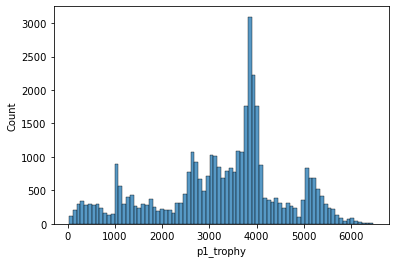

In [32]:
sns.histplot(df['p1_trophy'])

### Correlation Matrix

In [38]:
corr = df.corr()

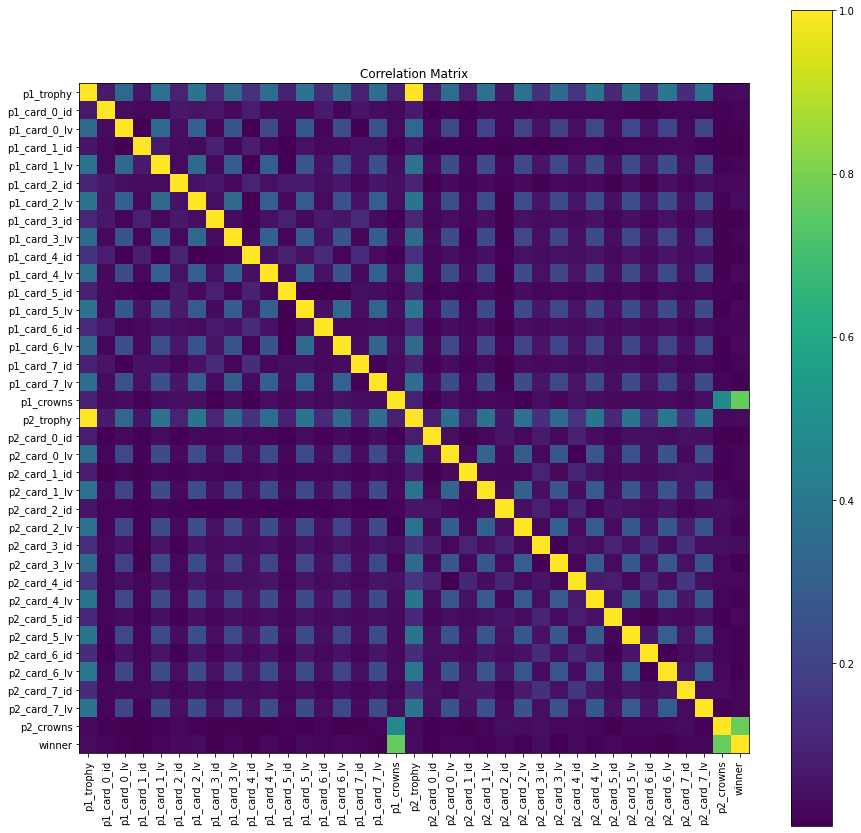

In [39]:
f = plt.figure(figsize=(15, 15))
plt.imshow(np.abs(corr))
plt.title('Correlation Matrix')
plt.xticks(np.arange(corr.shape[1]), corr.columns, rotation=90)
plt.yticks(np.arange(corr.shape[1]), corr.columns)
plt.colorbar()
plt.show()

#### Remarks:
From the plotted correlation matrix, we observe that there seems to be a clear relationship between:
- The level of cards that both players have
- The players' rankings (trophies) with each other
- Players' rankings (trophies) and cards in their deck

The first feature makes sense: Each player would try to upgrade their cards to the highest level possible. As guaranteed by the game's upgrade's algorithm, they should have cards at a same level.

Furthermore, the players' rankings should be correlated as well which is well supported by the graph. This is so because the game's "match-making process" is based on player rankings, (and players of different rankings seems to use similar decks of cards.) --- how?

However, unfortunately, it is evident that there is almost no correlation between the outcome and any other attributes of the dataset from this analysis. We can try to apply some well-known classifications methods and check if they give us promising results.

Let us now have a look at the card composition itself: We will remove the level of the cards for now.

In [40]:
less_cols = df.copy()
cols_to_drop = []
for col_name in df.columns:
    if 'lv' in col_name or 'tag' in col_name:
        cols_to_drop.append(col_name)
# remove cols with levels
less_cols.drop(columns=cols_to_drop, inplace=True)
less_corr = less_cols.corr()

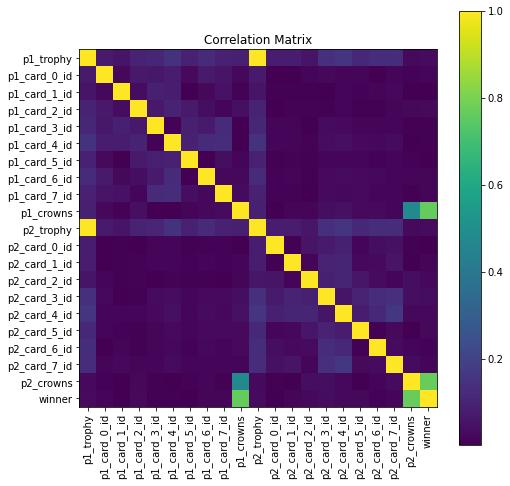

In [41]:
f = plt.figure(figsize=(8, 8))
plt.imshow(np.abs(less_corr))
plt.title('Correlation Matrix')
plt.xticks(np.arange(less_cols.shape[1]), less_cols.columns, rotation=90)
plt.yticks(np.arange(less_cols.shape[1]), less_cols.columns)
plt.colorbar()
plt.show()

Here we observe a different type of correlation. It appears that for each player, the card id that they have are slightly correlated.

This is because cards often have synergies (i.e some go well with others as support fillers while other do not), or as people call it - "meta". In this case, the results can be interpreted to explain that every card is followed by another specific card to complement the first one to build a strategy (catch: this is a strategy game). There are also relationships with further cards in the deck and even though they get weaker it is straightforward to realize that the cards are played out in a specific manner to build a strategy.

Let us observe this for different trophy ranges:

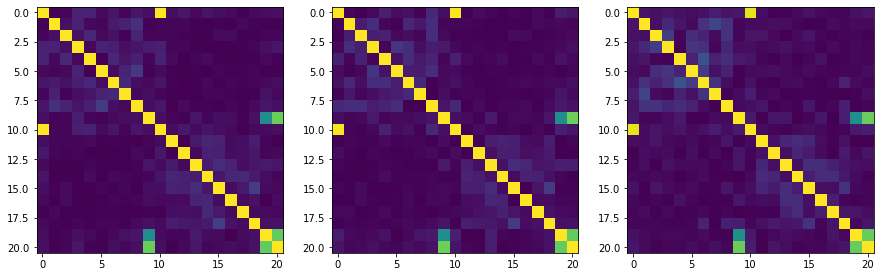

In [43]:
fig, ax = plt.subplots(1, 3, figsize=(15, 8))
ax[0].imshow(np.abs(
    less_cols[(less_cols['p1_trophy'] > 2000) 
              & (less_cols['p1_trophy'] < 3000)].corr()))
ax[1].imshow(np.abs(
    less_cols[(less_cols['p1_trophy'] > 2500) 
              & (less_cols['p1_trophy'] < 3000)].corr()))
ax[2].imshow(np.abs(
    less_cols[(less_cols['p1_trophy'] > 2800) 
              & (less_cols['p1_trophy'] < 3000)].corr()))

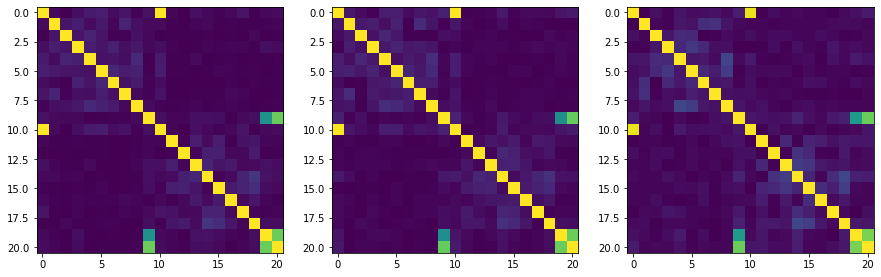

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(15, 8))
ax[0].imshow(np.abs(
    less_cols[(less_cols['p1_trophy'] > 3000) 
              & (less_cols['p1_trophy'] < 4000)].corr()))
ax[1].imshow(np.abs(
    less_cols[(less_cols['p1_trophy'] > 3500) 
              & (less_cols['p1_trophy'] < 4000)].corr()))
ax[2].imshow(np.abs(
    less_cols[(less_cols['p1_trophy'] > 3500) 
              & (less_cols['p1_trophy'] < 3700)].corr()))

As we can see, as we zoom into each trophy range, the correlation among cards becomes clearer. This makes sense, since each ranking has access to different cards, and thus the "meta" will be different among them.

### b. Understand Correlation of different features of the game

Here, we study the behaviour of three different aspects from the game based on the cards and try to see how they are related with the player who wins a particular match. These three different aspects include:
- **Average Deck Elixir**
- **Card Type**
- **Card Rarity**

**Average Deck Elixir:** In Clash Royale, every card has an elixir value which can be thought of as the cost to play that card in the game. This elixir is generated at a certain speed for every player and by playing a specific card, the elixir of that card is lost from the player's total elixir amount. This feature ensures that a player cannot play as many cards as he/she wants. In particular, this feature allows an opportunity for us to study the relation between the average elixir weight of a player's deck to the outcome of the game. In other words, our aim is to study if the player with a cheaper deck has a higher chance of winning the game. If this is the case, then we will have a correlation between the winner and the player who has cheaper deck.

**Card Type:** Every card in the game also has a type which can be thought of as a class of the card if it is a `Troop`, `Building`, or a `Spell`, and the cards do what the name of their class suggests. In particular, this feature may/may not have a relation between the type of cards of a player's deck and the outcome of the game. In other words, our aim is to study if a certain type of deck has a higher chance of winning the game. If this is the case, then we will have a correlation between the winner and the deck type. For our analysis, we will divide the `Troop` type in two categories `Air Troop` and `Ground Troop`.

**Card Rarity:** Furthermore, every card in the game also has a rarity which can be thought of as the abundance of the card in the game. Essentially there are 5 categories: `Common`, `Rare`, `Epic`, `Legendary`, and `Champion`. As the names suggest, these cards are decreasingly abundant in the game and it is harder to find these cards to upgrade their levels and play them. In particular, this is another feature that may/may not have a relation between the rarity of cards in a player's deck and the outcome of the game. In other words, our aim is to study if a certain rarity of a deck has a higher chance of winning the game. If this is the case, then we will have a correlation between the winner and the deck rarity.

In [46]:
# needed for id_map hashing
cards = pd.read_csv('data-cp/cards.csv')
cards_elixir = cards[['id', 'elixir']]

# create map for card ID and row
id_map = {}
for row in cards_elixir.index:
    id_map[cards_elixir.loc[row, 'id']] = row

In [47]:
p1_elixir = []
p2_elixir = []
p_elixir_greater = []

for (p1,p2) in zip(p1_cards.index, p2_cards.index):
    avg1 = 0
    avg2 = 0
    for i in range(8):
        card1 = id_map[p1_cards.iloc[p1, i]]
        card2 = id_map[p2_cards.iloc[p2, i]]

        avg1 += cards.at[card1,"elixir"]
        avg2 += cards.at[card2,"elixir"]
        
    avg1/=8.0
    avg2/=8.0
    p1_elixir.append(avg1)
    p2_elixir.append(avg2)
    if (avg1 > avg2):
        p_elixir_greater.append(1)
    elif(avg1 == avg2):
        p_elixir_greater.append(0)
    else:
        p_elixir_greater.append(2)

In [48]:
battles['p1_elixir'] = p1_elixir
battles['p2_elixir'] = p2_elixir
battles['p_elixir_greater'] = p_elixir_greater
df = battles[["winner", "p1_crowns", "p2_crowns", "p1_elixir", "p2_elixir", "p_elixir_greater"]]
print(df[543:549])

     winner  p1_crowns  p2_crowns  p1_elixir  p2_elixir  p_elixir_greater
543       2          0          3      2.875      3.750                 2
544       2          0          3      2.875      4.000                 2
545       2          0          1      2.875      4.500                 2
546       1          1          0      2.875      3.625                 2
547       2          0          1      3.375      3.750                 2
548       2          0          2      3.375      3.500                 2


In [49]:
corr = df.corr()

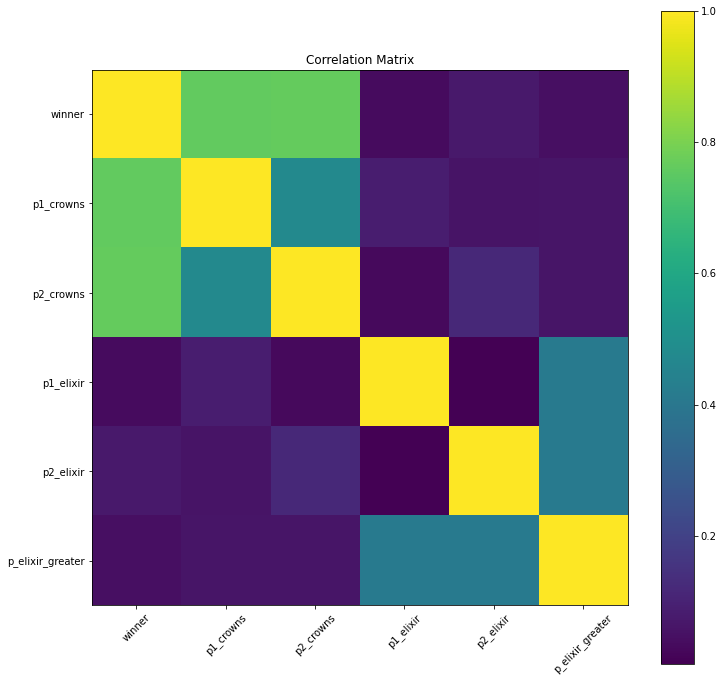

In [50]:
f = plt.figure(figsize=(12, 12))
plt.imshow(np.abs(corr))
plt.title('Correlation Matrix')
plt.xticks(np.arange(df.shape[1]), df.columns, rotation=45)
plt.yticks(np.arange(df.shape[1]), df.columns)
plt.colorbar()
plt.show()

### Troop Type

Now, we will try to analyze the decks based on the types of cards. In the original data, we have 3 types of cards: 
- `Troop`
- `Spell` 
- `Building`

But, we will divide the `Troop` type into:
- `Air_Troop` 
- `Ground_Troop`

The difference between these two is that `Air_Troop` have `flying_height>0` and as the name suggests, they are positioned above 0 on the z-axis in the game. The number of `Air_Troops` may/may not have an effect on the result of the match and that is why we will try to train our models and see if our predictions are any better with these troop types. We modify the data accordingly in the cell below. 

In [51]:
print("Unique cards before modification:", cards['type'].unique().tolist())
print(cards[['key', 'elixir', 'type']][:5])

for row_index in cards.index:
    if cards.loc[row_index, 'type'] == 'Troop':
        if cards.loc[row_index, 'flying_height'] > 0:
            cards.loc[row_index, 'type'] = 'Air_Troop'
        else:
            cards.loc[row_index, 'type'] = 'Ground_Troop'
print("")
print("Unique cards after modification:", sorted(cards['type'].unique()))
print(cards[['key', 'elixir', 'type', 'rarity']][:5])

Unique cards before modification: ['Troop', 'Building', 'Spell']
       key  elixir   type
0   knight       3  Troop
1  archers       3  Troop
2  goblins       2  Troop
3    giant       5  Troop
4    pekka       7  Troop

Unique cards after modification: ['Air_Troop', 'Building', 'Ground_Troop', 'Spell']
       key  elixir          type  rarity
0   knight       3  Ground_Troop  Common
1  archers       3  Ground_Troop  Common
2  goblins       2  Ground_Troop  Common
3    giant       5  Ground_Troop    Rare
4    pekka       7  Ground_Troop    Epic


In [52]:
encoding_type = {'Ground_Troop': 0, 'Air_Troop': 1, 'Building': 2, 'Spell': 3}
for row_index in cards.index:
    cards.loc[row_index, 'type'] = encoding_type[cards.loc[row_index, 'type']]
print("Cards after encoding:", sorted(cards['type'].unique()))
print(cards[['key', 'elixir', 'type']][67:80])

Cards after encoding: [0, 1, 2, 3]
                 key  elixir type
67     battle-healer       4    0
68     skeleton-king       4    0
69      archer-queen       5    0
70     golden-knight       4    0
71  skeleton-dragons       4    1
72      mother-witch       4    0
73    electro-spirit       1    0
74     electro-giant       7    0
75            cannon       3    2
76        goblin-hut       5    2
77            mortar       4    2
78     inferno-tower       5    2
79        bomb-tower       4    2


### Troop Rarity

Now, we will try to analyze the decks based on the rarity of cards. In the original data, we have 5 rarities of cards: 
- `Common`
- `Rare` 
- `Epic`
- `Legendary`
- `Champion` 


In [53]:
print("Unique cards before modification:", cards['type'].unique().tolist())
print(cards[['key', 'elixir', 'rarity']][:5])
encoding_rarity = {'Common': 0, 'Rare': 1, 'Epic': 2, 'Legendary': 3, 'Champion': 4}
for row_index in cards.index:
    cards.loc[row_index, 'rarity'] = encoding_rarity[cards.loc[row_index, 'rarity']]
print(cards[['key', 'elixir', 'type', 'rarity']][67:85])

Unique cards before modification: [0, 1, 2, 3]
       key  elixir  rarity
0   knight       3  Common
1  archers       3  Common
2  goblins       2  Common
3    giant       5    Rare
4    pekka       7    Epic
                 key  elixir type rarity
67     battle-healer       4    0      1
68     skeleton-king       4    0      4
69      archer-queen       5    0      4
70     golden-knight       4    0      4
71  skeleton-dragons       4    1      0
72      mother-witch       4    0      3
73    electro-spirit       1    0      0
74     electro-giant       7    0      2
75            cannon       3    2      0
76        goblin-hut       5    2      1
77            mortar       4    2      0
78     inferno-tower       5    2      1
79        bomb-tower       4    2      1
80     barbarian-hut       7    2      1
81             tesla       4    2      0
82  elixir-collector       6    2      1
83             x-bow       6    2      2
84         tombstone       3    2      1


### Troop Attack Grid

Now, we will try to analyze the decks based on the attack grid of cards. In the original data, a card has two values which correspond to its ability to attack in the air or on the ground. Every card can either attack only on the ground or both air and ground but no card can attack only in the air. So, we will add a new category in the data which classifies the attack grid of the corresponding card as either:
- `Ground`
- `Both`

This is a new feature to study so let's dive into it.

In [54]:
attack_range = []
for row_index in cards.index:
#     print(cards.loc[row_index])
    if cards.loc[row_index, 'damage_air']:
        attack_range.append('Both')
    else:
        attack_range.append('Ground')

cards['attack_grid'] = attack_range
print(cards[['key', 'elixir', 'type', 'rarity', 'attack_grid']][57:62])

               key  elixir type rarity attack_grid
57  flying-machine       4    1      1        Both
58   wall-breakers       2    0      2      Ground
59      royal-hogs       5    0      1      Ground
60    goblin-giant       6    0      2      Ground
61       fisherman       3    0      3      Ground


In [55]:
print("Unique cards before modification:", cards['attack_grid'].unique())
print(cards[['key', 'elixir', 'attack_grid']][:5])
encoding_attack = {'Ground': 0, 'Both': 1}
for row_index in cards.index:
    cards.loc[row_index, 'attack_grid'] = encoding_attack[cards.loc[row_index, 'attack_grid']]
print(cards[['key', 'elixir', 'type', 'attack_grid']][67:75])

Unique cards before modification: ['Ground' 'Both']
       key  elixir attack_grid
0   knight       3      Ground
1  archers       3        Both
2  goblins       2      Ground
3    giant       5      Ground
4    pekka       7      Ground
                 key  elixir type attack_grid
67     battle-healer       4    0           0
68     skeleton-king       4    0           0
69      archer-queen       5    0           1
70     golden-knight       4    0           0
71  skeleton-dragons       4    1           1
72      mother-witch       4    0           1
73    electro-spirit       1    0           1
74     electro-giant       7    0           0


### Feature Analysis

In [56]:
p1_t = []
p2_t = []
p1_r = []
p2_r = []
p1_a = []
p2_a = []
p_type_greater = []
p_rarity_greater = []
p_attack_greater = []

for (p1,p2) in zip(p1_cards.index, p2_cards.index):
    avg1_t = 0
    avg2_t = 0
    avg1_r = 0
    avg2_r = 0
    avg1_a = 0
    avg2_a = 0
    for i in range(8):
        card1 = id_map[p1_cards.iloc[p1, i]]
        card2 = id_map[p2_cards.iloc[p2, i]]

        avg1_t += cards.at[card1,"type"]
        avg2_t += cards.at[card2,"type"]
        
        avg1_r += cards.at[card1,"rarity"]
        avg2_r += cards.at[card2,"rarity"]
        
        avg1_a += cards.at[card1,"attack_grid"]
        avg2_a += cards.at[card2,"attack_grid"]
        
    # type average
    avg1_t/=8.0
    avg2_t/=8.0
    p1_t.append(avg1_t)
    p2_t.append(avg2_t)
    if (avg1_t > avg2_t):
        p_type_greater.append(1)
    elif(avg1_t == avg2_t):
        p_type_greater.append(0)
    else:
        p_type_greater.append(2)
        
    # rarity average
    avg1_r/=8.0
    avg2_r/=8.0
    p1_r.append(avg1_r)
    p2_r.append(avg2_r)
    if (avg1_t > avg2_t):
        p_rarity_greater.append(1)
    elif(avg1_t == avg2_t):
        p_rarity_greater.append(0)
    else:
        p_rarity_greater.append(2)
    
    # attack average
    avg1_a/=8.0
    avg2_a/=8.0
    p1_a.append(avg1_a)
    p2_a.append(avg2_a)
    if (avg1_a > avg2_a):
        p_attack_greater.append(1)
    elif(avg1_a == avg2_a):
        p_attack_greater.append(0)
    else:
        p_attack_greater.append(2)

In [57]:
battles['p1_type'] = p1_t
battles['p2_type'] = p2_t
battles['p_type_greater'] = p_type_greater
battles['p1_rarity'] = p1_r
battles['p2_rarity'] = p2_r
battles['p_rarity_greater'] = p_type_greater
battles['p1_attack'] = p1_a
battles['p2_attack'] = p2_a
battles['p_attack_greater'] = p_attack_greater
df = battles[["winner", "p1_crowns", "p2_crowns", "p1_elixir", "p2_elixir", "p_elixir_greater",
             "p1_type", "p2_type", "p_type_greater", "p1_rarity", "p2_rarity", "p_rarity_greater", 
             "p1_attack", "p2_attack", "p_attack_greater"]]
df[543:549]

,winner,p1_crowns,p2_crowns,p1_elixir,p2_elixir,p_elixir_greater,p1_type,p2_type,p_type_greater,p1_rarity,p2_rarity,p_rarity_greater,p1_attack,p2_attack,p_attack_greater
543,2,0,3,2.875,3.750,2,1.000,1.000,0,1.375,1.625,0,0.375,0.500,2
544,2,0,3,2.875,4.000,2,1.000,0.750,1,1.375,1.625,1,0.375,0.375,0
545,2,0,1,2.875,4.500,2,1.000,1.000,0,1.375,1.625,0,0.375,0.500,2
546,1,1,0,2.875,3.625,2,1.000,1.125,2,1.375,1.500,2,0.375,0.500,2
547,2,0,1,3.375,3.750,2,1.375,0.750,1,0.875,1.625,1,0.625,0.250,1
548,2,0,2,3.375,3.500,2,1.375,0.375,1,0.875,2.000,1,0.625,0.250,1


In [58]:
corr_var = df.corr()

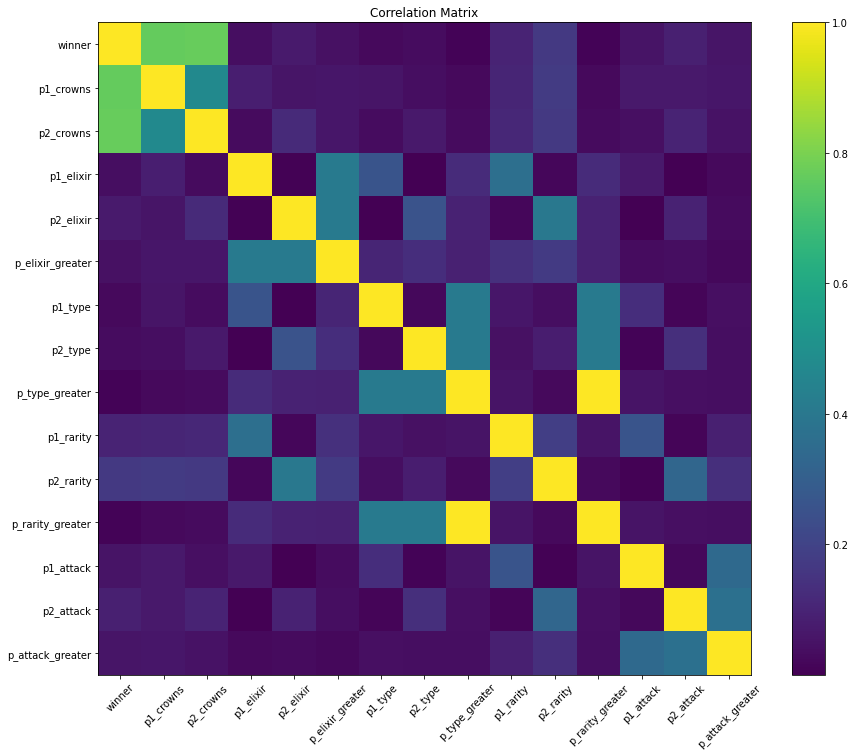

In [59]:
f = plt.figure(figsize=(15, 12))
plt.imshow(np.abs(corr_var))
plt.title('Correlation Matrix')
plt.xticks(np.arange(df.shape[1]), df.columns, rotation=45)
plt.yticks(np.arange(df.shape[1]), df.columns)
plt.colorbar()
plt.show()

### Remark

From this matrix we can see that there is a clear correlation between `p_type_greater` and `p_rarity_greater`. This essentially means that the player who has more spells

This time we add weights to the types and rarity of the cards and see if that gives a better relation.

In [60]:
# finding the number of cards by class name for every feature
nb_rarity = [0, 0, 0, 0, 0]
nb_type = [0, 0, 0, 0]
nb_attack = [0, 0]
for row in cards.index:
    nb_rarity[cards.loc[row, 'rarity']] += 1
    nb_type[cards.loc[row, 'type']] += 1
    nb_attack[cards.loc[row, 'attack_grid']] += 1
    
nb_rarity = [i/107.0 for i in nb_rarity]
nb_type = [i/107.0 for i in nb_type]
nb_attack = [i/107.0 for i in nb_attack]
print(sum(nb_type))
print(sum(nb_rarity))
print(sum(nb_attack))

1.0
1.0
1.0


In [61]:
# recasting all avergae data in the encoding maps
for i, val in enumerate(sorted(encoding_rarity)):
    encoding_rarity[val] = nb_rarity[i]
    
for i, val in enumerate(sorted(encoding_type)):
    encoding_type[val] = nb_type[i]

for i, val in enumerate(sorted(encoding_attack)):
    encoding_attack[val] = nb_attack[i]

# recasting the new
# we need a temporary array for that
cards_temp = pd.read_csv("data-cp/cards.csv")
for row_index in cards_temp.index:
    if cards_temp.loc[row_index, 'type'] == 'Troop':
        if cards_temp.loc[row_index, 'flying_height'] > 0:
            cards_temp.loc[row_index, 'type'] = 'Air_Troop'
        else:
            cards_temp.loc[row_index, 'type'] = 'Ground_Troop'
        
attack_range = []
for row_index in cards.index:
    if cards_temp.loc[row_index, 'damage_air']:
        attack_range.append('Both')
    else:
        attack_range.append('Ground')

cards_temp['attack_grid'] = attack_range
print(cards[['key', 'elixir', 'type', 'rarity', 'attack_grid']][57:62])
for row_index in cards.index:
    cards.loc[row_index, 'rarity'] = encoding_rarity[cards_temp.loc[row_index, 'rarity']]
    cards.loc[row_index, 'type'] = encoding_type[cards_temp.loc[row_index, 'type']]
    cards.loc[row_index, 'attack_grid'] = encoding_attack[cards_temp.loc[row_index, 'attack_grid']]
    
print(cards[['key', 'elixir', 'type', 'rarity', 'attack_grid']][67:72])
print("Types of cards:", sorted(cards['type'].unique()), " Sum: ", sum(cards['type'].unique()))
print("Rarity of cards:", sorted(cards['rarity'].unique()), " Sum: ", sum(cards['rarity'].unique()))
print("Attack of cards:", sorted(cards['attack_grid'].unique()), " Sum: ", sum(cards['attack_grid'].unique()))

               key  elixir type rarity attack_grid
57  flying-machine       4    1      1           1
58   wall-breakers       2    0      2           0
59      royal-hogs       5    0      1           0
60    goblin-giant       6    0      2           0
61       fisherman       3    0      3           0
                 key  elixir      type    rarity attack_grid
67     battle-healer       4  0.121495  0.037383    0.448598
68     skeleton-king       4  0.121495  0.261682    0.448598
69      archer-queen       5  0.121495  0.261682    0.551402
70     golden-knight       4  0.121495  0.261682    0.448598
71  skeleton-dragons       4  0.598131  0.261682    0.551402
Types of cards: [0.11214953271028037, 0.12149532710280374, 0.16822429906542055, 0.5981308411214953]  Sum:  1.0
Rarity of cards: [0.037383177570093455, 0.16822429906542055, 0.2616822429906542, 0.27102803738317754]  Sum:  0.7383177570093458
Attack of cards: [0.4485981308411215, 0.5514018691588785]  Sum:  1.0


In [62]:
# weighted average over all readings
p1_tw = []
p2_tw = []
p1_rw = []
p2_rw = []
p1_aw = []
p2_aw = []
p_type_greater = []
p_rarity_greater = []
p_attack_greater = []

for (p1,p2) in zip(p1_cards.index, p2_cards.index):
    avg1_tw = 0
    avg2_tw = 0
    avg1_rw = 0
    avg2_rw = 0
    avg1_aw = 0
    avg2_aw = 0
    for i in range(8):
        card1 = id_map[p1_cards.iloc[p1, i]]
        card2 = id_map[p2_cards.iloc[p2, i]]

        avg1_tw += cards.at[card1,"type"]
        avg2_tw += cards.at[card2,"type"]
        
        avg1_rw += cards.at[card1,"rarity"]
        avg2_rw += cards.at[card2,"rarity"]
        
        avg1_aw += cards.at[card1,"attack_grid"]
        avg2_aw += cards.at[card2,"attack_grid"]
        
    avg1_tw/=8.0
    avg2_tw/=8.0
    p1_tw.append(avg1_tw)
    p2_tw.append(avg2_tw)
    if (avg1_tw > avg2_tw):
        p_type_greater.append(1)
    elif(avg1_tw == avg2_tw):
        p_type_greater.append(0)
    else:
        p_type_greater.append(2)
        
    avg1_rw/=8.0
    avg2_rw/=8.0
    p1_rw.append(avg1_rw)
    p2_rw.append(avg2_rw)
    if (avg1_tw > avg2_tw):
        p_rarity_greater.append(1)
    elif(avg1_tw == avg2_tw):
        p_rarity_greater.append(0)
    else:
        p_rarity_greater.append(2)
        
    avg1_aw/=8.0
    avg2_aw/=8.0
    p1_aw.append(avg1_aw)
    p2_aw.append(avg2_aw)
    if (avg1_aw > avg2_aw):
        p_attack_greater.append(1)
    elif(avg1_aw == avg2_aw):
        p_attack_greater.append(0)
    else:
        p_attack_greater.append(2)

In [31]:
battles['p1_wtype'] = p1_tw
battles['p2_wtype'] = p2_tw
battles['p_w_type_greater'] = p_type_greater
battles['p1_wrarity'] = p1_rw
battles['p2_wrarity'] = p2_rw
battles['p_w_rarity_greater'] = p_type_greater
battles['p1_wattack'] = p1_aw
battles['p2_wattack'] = p2_aw
battles['p_w_attack_greater'] = p_attack_greater
df = battles[["winner", "p1_crowns", "p2_crowns", "p1_elixir", "p2_elixir", "p_elixir_greater",
             "p1_type", "p2_type", "p_type_greater", "p1_wtype", "p2_wtype", "p_w_type_greater", 
              "p1_wrarity", "p2_wrarity", "p_w_rarity_greater",  "p1_rarity", "p2_rarity", "p_rarity_greater",
             "p1_wattack", "p2_wattack", "p_w_attack_greater", "p1_attack", "p2_attack", "p_attack_greater"]]
print(df[543:549])

     winner  p1_crowns  p2_crowns  p1_elixir  p2_elixir  p_elixir_greater  \
543       2          0          3      2.875      3.750                 2   
544       2          0          3      2.875      4.000                 2   
545       2          0          1      2.875      4.500                 2   
546       1          1          0      2.875      3.625                 2   
547       2          0          1      3.375      3.750                 2   
548       2          0          2      3.375      3.500                 2   

     p1_type  p2_type  p_type_greater  p1_wtype  ...  p_w_rarity_greater  \
543    1.000    1.000               0  0.132009  ...                   2   
544    1.000    0.750               1  0.132009  ...                   2   
545    1.000    1.000               0  0.132009  ...                   0   
546    1.000    1.125               2  0.132009  ...                   2   
547    1.375    0.750               1  0.137850  ...                   1   
548 

In [32]:
corr_wvar = df.corr()

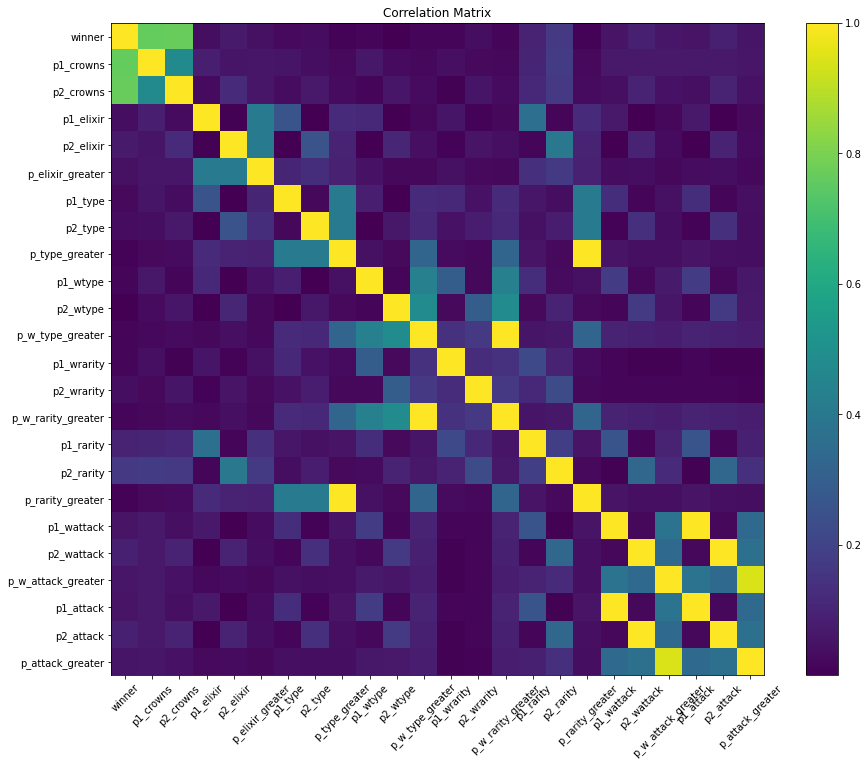

In [33]:
f = plt.figure(figsize=(15, 12))
plt.imshow(np.abs(corr_wvar))
plt.title('Correlation Matrix')
plt.xticks(np.arange(df.shape[1]), df.columns, rotation=45)
plt.yticks(np.arange(df.shape[1]), df.columns)
plt.colorbar()
plt.show()

## 4. Decks Analysis:
Let us dig deeper into the dataset by analyzing the decks, which seems to be most correlated.

We first visualize the correlation matrix (now with the new encoding).

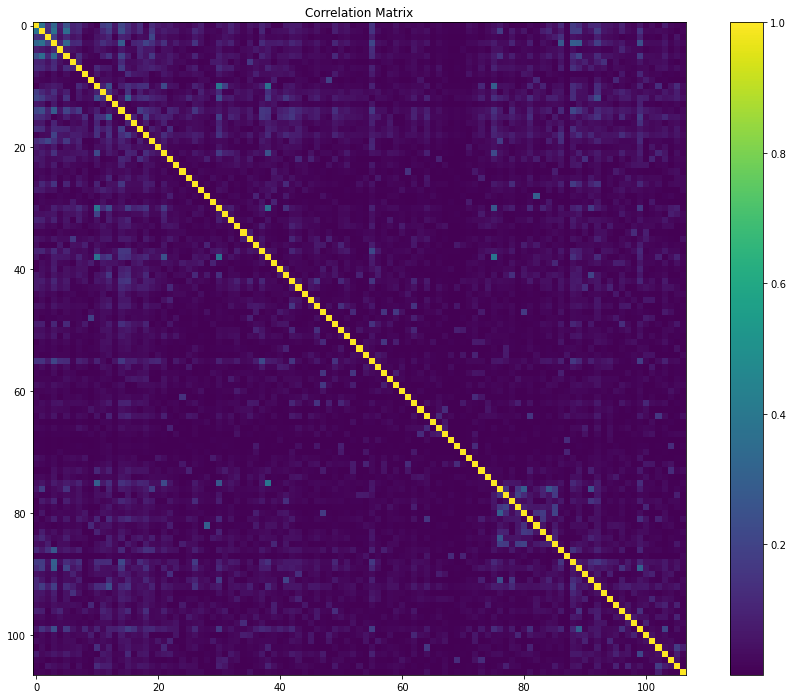

In [63]:
d_corr = np.corrcoef(decks.T)
f = plt.figure(figsize=(16, 12))
plt.imshow(np.abs(d_corr))
plt.title('Correlation Matrix')
plt.colorbar()
plt.show()

#### Remarks:
We want to observe which pairs have the highest synergy. The following cells sets all correlation under the diagonal to 0, and sort them by value.

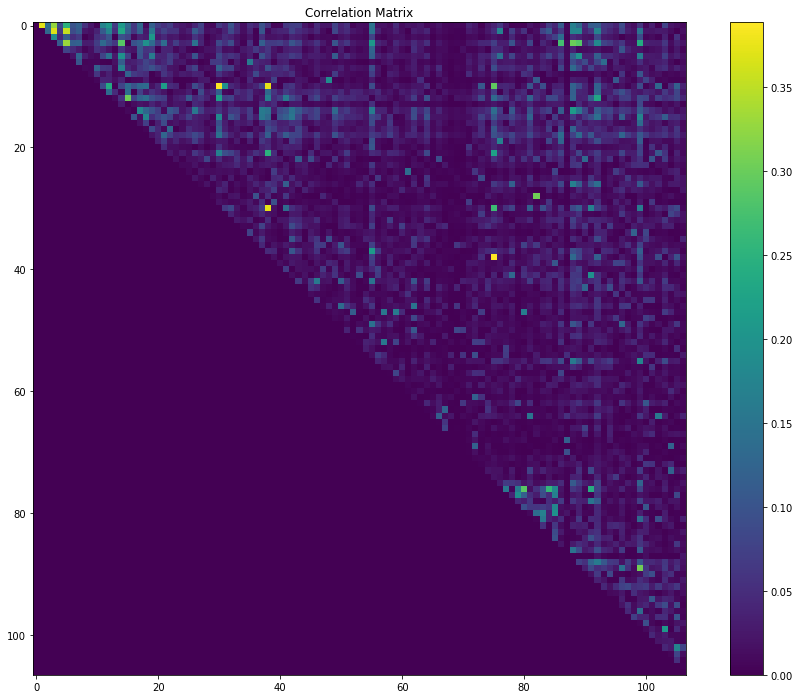

In [64]:
d_corr_u = np.triu(d_corr, k=1)
d_corr_u
f = plt.figure(figsize=(16, 12))
plt.imshow(np.abs(d_corr_u))
plt.title('Correlation Matrix')
plt.colorbar()
plt.show()

In [67]:
id_map_inv = {}
for i in id_map:
    id_map_inv[id_map[i]] = i
d_corr_flat = d_corr_u.flatten()
d_corr_argsort = np.argsort(d_corr_flat)
d_corr_high = [(x // 107, x % 107, d_corr_flat[x]) for x in d_corr_argsort[:-31:-1]]
d_corr_low = [(x // 107, x % 107, d_corr_flat[x]) for x in d_corr_argsort[:30]]

In [68]:
# [(cards[id_map[x]], cards[id_map[y]], z) for (x, y, z) in d_corr_high]

KeyError: 10

In [70]:
# [(cards[x], cards[y], z) for (x, y, z) in d_corr_low]

#### Remarks:
We observe that these card pairs are very common in the strongest decks (from https://www.deckshop.pro/).

## 5. A deeper look at Outcome:
### a. Applying PCA:

In [71]:
data = np.copy(x_train).T.tolist()
data.append(y_train)
data = np.array(data)

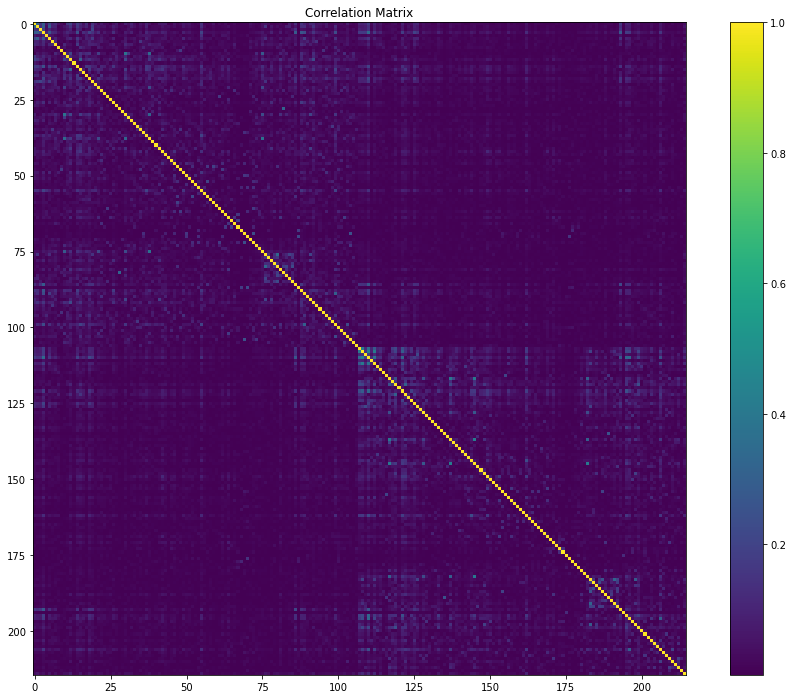

In [72]:
corr = np.corrcoef(data)
f = plt.figure(figsize=(16, 12))
plt.imshow(np.abs(corr))
plt.title('Correlation Matrix')
plt.colorbar()
plt.show()

In [73]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
x_train_pca = pca.fit_transform(x_train)

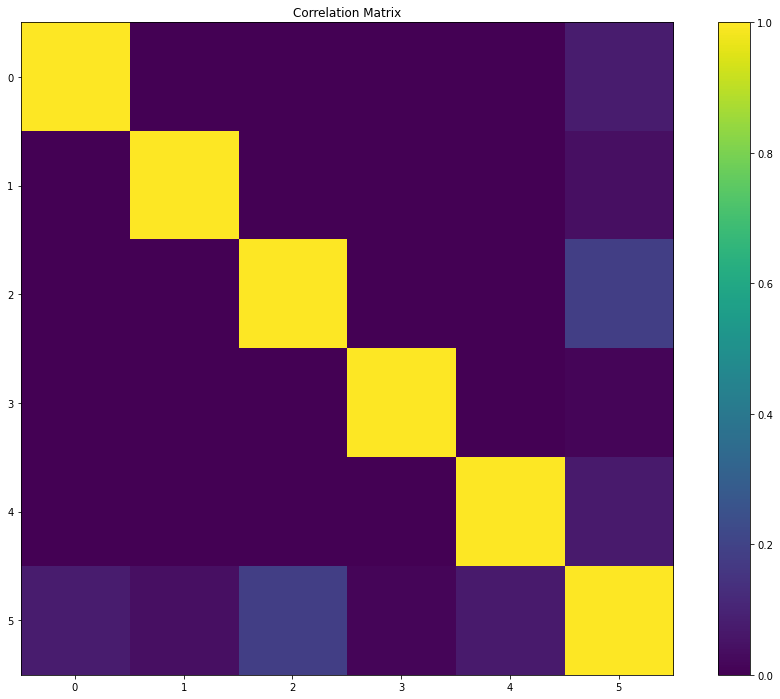

In [74]:
data = np.copy(x_train_pca).T.tolist()
data.append(y_train)
data = np.array(data)
corr = np.corrcoef(data)
f = plt.figure(figsize=(16, 12))
plt.imshow(np.abs(corr))
plt.title('Correlation Matrix')
plt.colorbar()
plt.show()

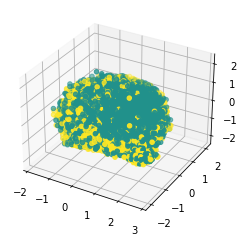

In [75]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x_train_pca[:,0].flatten(), x_train_pca[:, 1].flatten(), x_train_pca[:, 2].flatten(), c = y_train.tolist())

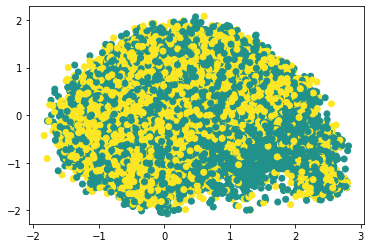

In [76]:
plt.scatter(x_train_pca[:,0].flatten(), x_train_pca[:, 1].flatten(), c = y_train.tolist())

In [77]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=20))
ada.fit(x_train_pca, y_train)
print('Training accuracy:\t', ada.score(x_train_pca, y_train))
print('Testing accuracy:\t', ada.score(pca.transform(x_test), y_test))

Training accuracy:	 0.9965054959018997
Testing accuracy:	 0.5458703939008894


In [78]:
extra = ExtraTreesClassifier(max_depth=20)
extra.fit(x_train_pca, y_train)
print('Training accuracy:\t', extra.score(x_train_pca, y_train))
print('Testing accuracy:\t', extra.score(pca.transform(x_test), y_test))

Training accuracy:	 0.9946947074147023
Testing accuracy:	 0.5709021601016518


In [79]:
rf = RandomForestClassifier(max_depth=20)
rf.fit(x_train_pca, y_train)
print('Training accuracy:\t', rf.score(x_train_pca, y_train))
print('Testing accuracy:\t', rf.score(pca.transform(x_test), y_test))

Training accuracy:	 0.9919626405743694
Testing accuracy:	 0.5637865311308767


In [80]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(x_train, y_train)
print('Training accuracy:\t', gnb.score(x_train, y_train))
print('Testing accuracy:\t', gnb.score(x_test, y_test))

Training accuracy:	 0.5814537137048097
Testing accuracy:	 0.5744599745870393


### b. How about Neural Network?
Let's try to see if we can instead obtain a good score using Neural Network. 

We first try a naive Neural Network, with all layers are dense, and two Dropouts.

In [81]:
y_train

17349    2
38279    1
18713    2
27073    1
19806    1
        ..
17561    1
29820    2
23022    2
9369     1
18374    1
Name: winner, Length: 31478, dtype: int64

In [82]:
from tensorflow import keras
nn = keras.Sequential([
    keras.layers.Dense(106, activation='relu'),
    keras.layers.Dense(53, activation='tanh'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(26, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(13, activation='relu'),
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(3, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation='sigmoid'),
])
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=2)
nn.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=['accuracy'],
)
nn.fit(x_train, y_train-1, validation_split=0.1, epochs=10, batch_size=16, callbacks=[early_stopping])

2022-05-07 16:19:17.267828: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-05-07 16:19:17.279803: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 3600000000 Hz
2022-05-07 16:19:17.280534: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55abc929f1e0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-07 16:19:17.280552: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-05-07 16:19:17.280628: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1771/1771 [==============================] - 6s 4ms/step - loss: 0.8577 - accuracy: 0.4935 - val_loss: 0.7492 - val_accuracy: 0.5016
Epoch 2/10
1771/1771 [==============================] - 6s 3ms/step - loss: 0.8315 - accuracy: 0.4952 - val_loss: 0.7338 - val_accuracy: 0.5064
Epoch 3/10
1771/1771 [==============================] - 6s 4ms/step - loss: 0.8158 - accuracy: 0.4949 - val_loss: 0.7268 - val_accuracy: 0.5098
Epoch 4/10
1771/1771 [==============================] - 6s 3ms/step - loss: 

In [83]:
nn.evaluate(x_test, y_test-1)

246/246 [==============================] - 0s 1ms/step - loss: 0.7037 - accuracy: 0.4975


[0.7037022113800049, 0.49745869636535645]

#### Remarks: 
The previous one did not really give a very good score, so let's try to see if we could use a different network structure.

Through the previous analysis on Decks, we observe that a deck is characterized by a small number of cards. With that in mind, it makes sense to use CNN on this model, as in the following cell.

In [109]:
x_train.shape

(31478, 214)

In [112]:
from tensorflow import keras
cnn = keras.Sequential([
    keras.layers.Dense(214 * 2, activation='relu', input_shape=(214, 1)),
    keras.layers.Conv1D(32, 8, padding='same', activation='relu'),
    keras.layers.Conv1D(32, 8, activation='relu'),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool1D(4),
    keras.layers.Conv1D(64, 8, activation='relu'),
    keras.layers.Conv1D(64, 8, activation='relu'),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPool1D(4),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])
early_stopping = keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)
cnn.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=['accuracy'],
)

cnn.fit(x_train.reshape((x_train.shape[0], x_train.shape[1], 1)), y_train-1, validation_split=0.1, epochs=30, batch_size=16, callbacks=[early_stopping])
# cnn.fit(x_train, y_train-1, validation_split=0.1, epochs=30, batch_size=16, callbacks=[early_stopping])

Epoch 1/30
1771/1771 [==============================] - 61s 34ms/step - loss: 0.7848 - accuracy: 0.5024 - val_loss: 0.7027 - val_accuracy: 0.5086
Epoch 2/30
1771/1771 [==============================] - 55s 31ms/step - loss: 0.7241 - accuracy: 0.5063 - val_loss: 0.7016 - val_accuracy: 0.5085
Epoch 3/30
1771/1771 [==============================] - 60s 34ms/step - loss: 0.7120 - accuracy: 0.5095 - val_loss: 0.6994 - val_accuracy: 0.5068
Epoch 4/30
1771/1771 [==============================] - 56s 32ms/step - loss: 0.7056 - accuracy: 0.5116 - val_loss: 0.6975 - val_accuracy: 0.5067
Epoch 5/30
1771/1771 [==============================] - 61s 34ms/step - loss: 0.7024 - accuracy: 0.5124 - val_loss: 0.6970 - val_accuracy: 0.5065
Epoch 6/30
1771/1771 [==============================] - 57s 32ms/step - loss: 0.7008 - accuracy: 0.5109 - val_loss: 0.6963 - val_accuracy: 0.5063
Epoch 7/30
1771/1771 [==============================] - 59s 33ms/step - loss: 0.6990 - accuracy: 0.5126 - val_loss: 0.6952 -

KeyboardInterrupt: 

In [96]:
cnn.evaluate(x_test.reshape((x_test.shape[0], x_test.shape[1], 1)), y_test-1)

246/246 [==============================] - 9s 37ms/step - loss: 0.6808 - accuracy: 0.5330


[0.6807851791381836, 0.5330368876457214]

#### Remarks:
The result indeed looks better than our naive model. We observe that indeed, it is better to look at a match in terms of a combination of cards instead of each in particular. However, it appears that, unfortunately, we cannot really get a very good prediction of outcome than decision trees.

A limitation to this model is that the convolutional layer would only consider a small subset of cards that have similar `id`. As a result, since cards that are used together usually do not have consecutive `id`, it would fail to take into account this factor. We have tried to remedy this by introducing a `Dense` layer as the first layer to remap the input, but this does not really give a much better prediction.

### Algorithms for Card types, rarity, elixir

In [97]:
print(cards.describe())
print("")
print("")
print(id_map)
print(cards[['key', 'elixir', 'type', 'rarity', 'attack_grid']][67:72])

           elixir            id  flying_height         range
count  107.000000  1.070000e+02     107.000000    107.000000
mean     3.981308  2.647666e+07     318.691589   2346.261682
std      1.601776  7.812031e+05     957.801220   2546.387572
min      1.000000  2.600000e+07       0.000000      0.000000
25%      3.000000  2.600003e+07       0.000000    500.000000
50%      4.000000  2.600005e+07       0.000000   1200.000000
75%      5.000000  2.700000e+07       0.000000   4500.000000
max      9.000000  2.800002e+07    4000.000000  11500.000000


{26000000: 0, 26000001: 1, 26000002: 2, 26000003: 3, 26000004: 4, 26000005: 5, 26000006: 6, 26000007: 7, 26000008: 8, 26000009: 9, 26000010: 10, 26000011: 11, 26000012: 12, 26000013: 13, 26000014: 14, 26000015: 15, 26000016: 16, 26000017: 17, 26000018: 18, 26000019: 19, 26000020: 20, 26000021: 21, 26000022: 22, 26000023: 23, 26000024: 24, 26000025: 25, 26000026: 26, 26000027: 27, 26000028: 28, 26000029: 29, 26000030: 30, 26000031: 31, 26000032: 

In [98]:
from sklearn.model_selection import train_test_split
df = battles[(battles['p1_trophy'] < 2700) & (battles['p1_trophy'] > 600)]
y_train = df['winner']
x_train, decks = [], []

# we first combine the DataFrame into 1x106 vectors, where V[i] = 1 if the ith card is in the deck
# this 
for i in df.index:
    t1 = np.zeros(107)
    t2 = np.zeros(107)
    r1 = np.zeros(107)
    r2 = np.zeros(107)
    e1 = np.zeros(107)
    e2 = np.zeros(107)
    for j in range(0, 8):
        card1 = df[f'p1_card_{j}_id'][i]
        card2 = df[f'p2_card_{j}_id'][i]
        
        t1[id_map[card1]] = cards.at[id_map[card1],"type"]
        t2[id_map[card2]] = cards.at[id_map[card2],"type"]
        
        r1[id_map[card1]] = cards.at[id_map[card1],"rarity"]
        r2[id_map[card2]] = cards.at[id_map[card2],"rarity"]
        
        e1[id_map[card1]] = cards.at[id_map[card1],"elixir"]
        e2[id_map[card2]] = cards.at[id_map[card2],"elixir"]
        
    x_train.append(np.concatenate((t1, t2, r1, r2, e1, e2)))
    
x_train = np.array(x_train)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=6233)
# d_train, d_test = train_test_split(decks, test_size=0.2, random_state=47483)

In [99]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
print('Training accuracy:\t', knn.score(x_train, y_train))
print('Testing accuracy:\t', knn.score(x_test, y_test))

Training accuracy:	 0.7409582276791672
Testing accuracy:	 0.5939167556029883


In [100]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=20))
ada.fit(x_train, y_train)
print('Training accuracy:\t', ada.score(x_train, y_train))
print('Testing accuracy:\t', ada.score(x_test, y_test))

Training accuracy:	 0.9971973842252769
Testing accuracy:	 0.5784418356456777


In [101]:
bagging = BaggingClassifier(DecisionTreeClassifier(max_depth=20))
bagging.fit(x_train, y_train)
print('Training accuracy:\t', bagging.score(x_train, y_train))
print('Testing accuracy:\t', bagging.score(x_test, y_test))

Training accuracy:	 0.9603630054717737
Testing accuracy:	 0.5896478121664888


In [102]:
extra = ExtraTreesClassifier(max_depth=20)
extra.fit(x_train, y_train)
print('Training accuracy:\t', extra.score(x_train, y_train))
print('Testing accuracy:\t', extra.score(x_test, y_test))

Training accuracy:	 0.9945282263445883
Testing accuracy:	 0.6099252934898612


In [103]:
rf = RandomForestClassifier(max_depth=20)
rf.fit(x_train, y_train)
print('Training accuracy:\t', rf.score(x_train, y_train))
print('Testing accuracy:\t', rf.score(x_test, y_test))

Training accuracy:	 0.9894568263712799
Testing accuracy:	 0.6067235859124867


### Neural Network for Card types, rarity, elixir

In [104]:
from tensorflow import keras
nn = keras.Sequential([
    keras.layers.Dense(106, activation='relu'),
    keras.layers.Dense(53, activation='tanh'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(26, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(13, activation='relu'),
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(3, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation='sigmoid'),
])
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=2)
nn.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=['accuracy'],
)
nn.fit(x_train, y_train-1, validation_split=0.1, epochs=10, batch_size=16, callbacks=[early_stopping])

Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

422/422 [==============================] - 2s 5ms/step - loss: 0.7538 - accuracy: 0.4890 - val_loss: 0.7020 - val_accuracy: 0.4773
Epoch 2/10
422/422 [==============================] - 2s 4ms/step - loss: 0.7470 - accuracy: 0.4940 - val_loss: 0.7040 - val_accuracy: 0.4853
Epoch 3/10
422/422 [==============================] - 1s 3ms/step - loss: 0.7505 - accuracy: 0.4888 - val_loss: 0.7048 - val_accuracy: 0.4960
Epoch 4/10
422/422 [==============================] - 1s 3ms/step - loss: 0.7443 -

### Algorithms for Card types

In [105]:
x_train, decks = [], []

# we first combine the DataFrame into 1x106 vectors, where V[i] = 1 if the ith card is in the deck
# this 
for i in df.index:
    t1 = np.zeros(107)
    t2 = np.zeros(107)
    for j in range(0, 8):
        card1 = df[f'p1_card_{j}_id'][i]
        card2 = df[f'p2_card_{j}_id'][i]
        
        t1[id_map[card1]] = cards.at[id_map[card1],"type"]
        t2[id_map[card2]] = cards.at[id_map[card2],"type"]
        
    x_train.append(np.concatenate((t1, t2)))
    
x_train = np.array(x_train)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=6233)
# d_train, d_test = train_test_split(decks, test_size=0.2, random_state=47483)

ValueError: Found input variables with inconsistent numbers of samples: [9367, 7493]

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
print('Training accuracy:\t', knn.score(x_train, y_train))
print('Testing accuracy:\t', knn.score(x_test, y_test))

In [ ]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=20))
ada.fit(x_train, y_train)
print('Training accuracy:\t', ada.score(x_train, y_train))
print('Testing accuracy:\t', ada.score(x_test, y_test))

In [ ]:
bagging = BaggingClassifier(DecisionTreeClassifier(max_depth=20))
bagging.fit(x_train, y_train)
print('Training accuracy:\t', bagging.score(x_train, y_train))
print('Testing accuracy:\t', bagging.score(x_test, y_test))

In [ ]:
extra = ExtraTreesClassifier(max_depth=20)
extra.fit(x_train, y_train)
print('Training accuracy:\t', extra.score(x_train, y_train))
print('Testing accuracy:\t', extra.score(x_test, y_test))

In [ ]:
rf = RandomForestClassifier(max_depth=20)
rf.fit(x_train, y_train)
print('Training accuracy:\t', rf.score(x_train, y_train))
print('Testing accuracy:\t', rf.score(x_test, y_test))

### Neural Network for Card types

In [ ]:
from tensorflow import keras
nn = keras.Sequential([
    keras.layers.Dense(106, activation='relu'),
    keras.layers.Dense(53, activation='tanh'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(26, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(13, activation='relu'),
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(3, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation='sigmoid'),
])
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=2)
nn.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=['accuracy'],
)
nn.fit(x_train, y_train-1, validation_split=0.1, epochs=10, batch_size=16, callbacks=[early_stopping])

### Algorithms for Card rarity

In [ ]:
x_train, decks = [], []

# we first combine the DataFrame into 1x106 vectors, where V[i] = 1 if the ith card is in the deck
# this 
for i in df.index:
    r1 = np.zeros(107)
    r2 = np.zeros(107)
    for j in range(0, 8):
        card1 = df[f'p1_card_{j}_id'][i]
        card2 = df[f'p2_card_{j}_id'][i]
        
        r1[id_map[card1]] = cards.at[id_map[card1],"rarity"]
        r2[id_map[card2]] = cards.at[id_map[card2],"rarity"]
        
    x_train.append(np.concatenate((r1, r2)))
    
x_train = np.array(x_train)
y_train = df['winner']
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=6233)
# d_train, d_test = train_test_split(decks, test_size=0.2, random_state=47483)

In [248]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
print('Training accuracy:\t', knn.score(x_train, y_train))
print('Testing accuracy:\t', knn.score(x_test, y_test))

Training accuracy:	 0.733484585613239
Testing accuracy:	 0.5586979722518677


In [249]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=20))
ada.fit(x_train, y_train)
print('Training accuracy:\t', ada.score(x_train, y_train))
print('Testing accuracy:\t', ada.score(x_test, y_test))

Training accuracy:	 0.9971973842252769
Testing accuracy:	 0.5917822838847385


In [250]:
bagging = BaggingClassifier(DecisionTreeClassifier(max_depth=20))
bagging.fit(x_train, y_train)
print('Training accuracy:\t', bagging.score(x_train, y_train))
print('Testing accuracy:\t', bagging.score(x_test, y_test))

Training accuracy:	 0.9551581476044309
Testing accuracy:	 0.5773745997865528


In [251]:
extra = ExtraTreesClassifier(max_depth=20)
extra.fit(x_train, y_train)
print('Training accuracy:\t', extra.score(x_train, y_train))
print('Testing accuracy:\t', extra.score(x_test, y_test))

Training accuracy:	 0.9935940210863473
Testing accuracy:	 0.6125933831376734


In [252]:
rf = RandomForestClassifier(max_depth=20)
rf.fit(x_train, y_train)
print('Training accuracy:\t', rf.score(x_train, y_train))
print('Testing accuracy:\t', rf.score(x_test, y_test))

Training accuracy:	 0.9865207527025224
Testing accuracy:	 0.5976520811099253


### Neural Network for Card rarity

In [262]:
from tensorflow import keras
nn = keras.Sequential([
    keras.layers.Dense(106, activation='relu'),
    keras.layers.Dense(53, activation='tanh'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(26, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(13, activation='relu'),
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(3, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation='sigmoid'),
])
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=2)
nn.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=['accuracy'],
)
nn.fit(x_train, y_train-1, validation_split=0.1, epochs=10, batch_size=16, callbacks=[early_stopping])

Epoch 1/10
422/422 [==============================] - 5s 6ms/step - loss: 0.8006 - accuracy: 0.5145 - val_loss: 0.7192 - val_accuracy: 0.5160
Epoch 2/10
422/422 [==============================] - 2s 5ms/step - loss: 0.8052 - accuracy: 0.5087 - val_loss: 0.7309 - val_accuracy: 0.5160
Epoch 3/10
422/422 [==============================] - 2s 6ms/step - loss: 0.7809 - accuracy: 0.5235 - val_loss: 0.7326 - val_accuracy: 0.5093
Epoch 4/10
422/422 [==============================] - 3s 6ms/step - loss: 0.7896 - accuracy: 0.5106 - val_loss: 0.7249 - val_accuracy: 0.5227
Epoch 5/10
422/422 [==============================] - 3s 7ms/step - loss: 0.7905 - accuracy: 0.5124 - val_loss: 0.7226 - val_accuracy: 0.5213


### Algorithms for Card elixir

In [269]:
x_train, decks = [], []

# we first combine the DataFrame into 1x106 vectors, where V[i] = 1 if the ith card is in the deck
# this 
for i in df.index:
    e1 = np.zeros(107)
    e2 = np.zeros(107)
    for j in range(0, 8):
        card1 = df[f'p1_card_{j}_id'][i]
        card2 = df[f'p2_card_{j}_id'][i]
        
        e1[id_map[card1]] = cards.at[id_map[card1],"elixir"]
        e2[id_map[card2]] = cards.at[id_map[card2],"elixir"]
        
    x_train.append(np.concatenate((e1, e2)))
    
x_train = np.array(x_train)
y_train = df['winner']
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=6233)
# d_train, d_test = train_test_split(decks, test_size=0.2, random_state=47483)

In [270]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
print('Training accuracy:\t', knn.score(x_train, y_train))
print('Testing accuracy:\t', knn.score(x_test, y_test))

Training accuracy:	 0.7392232750567196
Testing accuracy:	 0.5923159018143009


In [271]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=20))
ada.fit(x_train, y_train)
print('Training accuracy:\t', ada.score(x_train, y_train))
print('Testing accuracy:\t', ada.score(x_test, y_test))

Training accuracy:	 0.9971973842252769
Testing accuracy:	 0.5912486659551761


In [272]:
bagging = BaggingClassifier(DecisionTreeClassifier(max_depth=20))
bagging.fit(x_train, y_train)
print('Training accuracy:\t', bagging.score(x_train, y_train))
print('Testing accuracy:\t', bagging.score(x_test, y_test))

Training accuracy:	 0.9579607633791539
Testing accuracy:	 0.583778014941302


In [273]:
extra = ExtraTreesClassifier(max_depth=20)
extra.fit(x_train, y_train)
print('Training accuracy:\t', extra.score(x_train, y_train))
print('Testing accuracy:\t', extra.score(x_test, y_test))

Training accuracy:	 0.993193647404244
Testing accuracy:	 0.6141942369263608


In [274]:
rf = RandomForestClassifier(max_depth=20)
rf.fit(x_train, y_train)
print('Training accuracy:\t', rf.score(x_train, y_train))
print('Testing accuracy:\t', rf.score(x_test, y_test))

Training accuracy:	 0.9874549579607633
Testing accuracy:	 0.5976520811099253


### Neural Network for Card elixir

In [264]:
from tensorflow import keras
nn = keras.Sequential([
    keras.layers.Dense(106, activation='relu'),
    keras.layers.Dense(53, activation='tanh'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(26, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(13, activation='relu'),
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(3, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation='sigmoid'),
])
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=2)
nn.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=['accuracy'],
)
nn.fit(x_train, y_train-1, validation_split=0.1, epochs=10, batch_size=16, callbacks=[early_stopping])

Epoch 1/10
422/422 [==============================] - 5s 6ms/step - loss: 0.7712 - accuracy: 0.4927 - val_loss: 0.7302 - val_accuracy: 0.4653
Epoch 2/10
422/422 [==============================] - 2s 5ms/step - loss: 0.7605 - accuracy: 0.4967 - val_loss: 0.7307 - val_accuracy: 0.4653
Epoch 3/10
422/422 [==============================] - 2s 5ms/step - loss: 0.7549 - accuracy: 0.5032 - val_loss: 0.7308 - val_accuracy: 0.4680
Epoch 4/10
422/422 [==============================] - 2s 5ms/step - loss: 0.7620 - accuracy: 0.4909 - val_loss: 0.7284 - val_accuracy: 0.4640
Epoch 5/10
422/422 [==============================] - 2s 5ms/step - loss: 0.7501 - accuracy: 0.4973 - val_loss: 0.7233 - val_accuracy: 0.4800
Epoch 6/10
422/422 [==============================] - 2s 5ms/step - loss: 0.7491 - accuracy: 0.5013 - val_loss: 0.7235 - val_accuracy: 0.4733
Epoch 7/10
422/422 [==============================] - 2s 5ms/step - loss: 0.7497 - accuracy: 0.4949 - val_loss: 0.7235 - val_accuracy: 0.4627
Epoch 

### Algorithms for Card types, rarity, elixir

In [267]:
df.shape

(9367, 60)

In [265]:
x_train, decks = [], []

items = df.shape[0]
# we first combine the DataFrame into 1x106 vectors, where V[i] = 1 if the ith card is in the deck
for i in df.index:
    t1 = np.zeros(it)
    t2 = np.zeros(107)
    r1 = np.zeros(107)
    r2 = np.zeros(107)
    e1 = np.zeros(107)
    e2 = np.zeros(107)
    for j in range(0, 8):
        card1 = df[f'p1_card_{j}_id'][i]
        card2 = df[f'p2_card_{j}_id'][i]
        
        t1[id_map[card1]] = cards.at[id_map[card1],"type"]
        t2[id_map[card2]] = cards.at[id_map[card2],"type"]
        
        r1[id_map[card1]] = cards.at[id_map[card1],"rarity"]
        r2[id_map[card2]] = cards.at[id_map[card2],"rarity"]
        
        e1[id_map[card1]] = cards.at[id_map[card1],"elixir"]
        e2[id_map[card2]] = cards.at[id_map[card2],"elixir"]
        
    x_train.append(np.concatenate((t1, t2, r1, r2, e1, e2)))
    
y_train = df['winner']
x_train = np.array(x_train)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=6233)
# d_train, d_test = train_test_split(decks, test_size=0.2, random_state=47483)

In [220]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
print('Training accuracy:\t', knn.score(x_train, y_train))
print('Testing accuracy:\t', knn.score(x_test, y_test))

Training accuracy:	 0.7409582276791672
Testing accuracy:	 0.5939167556029883


In [221]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=20))
ada.fit(x_train, y_train)
print('Training accuracy:\t', ada.score(x_train, y_train))
print('Testing accuracy:\t', ada.score(x_test, y_test))

Training accuracy:	 0.9971973842252769
Testing accuracy:	 0.5741728922091782


In [222]:
bagging = BaggingClassifier(DecisionTreeClassifier(max_depth=20))
bagging.fit(x_train, y_train)
print('Training accuracy:\t', bagging.score(x_train, y_train))
print('Testing accuracy:\t', bagging.score(x_test, y_test))

Training accuracy:	 0.9526224476177766
Testing accuracy:	 0.5944503735325507


In [223]:
extra = ExtraTreesClassifier(max_depth=20)
extra.fit(x_train, y_train)
print('Training accuracy:\t', extra.score(x_train, y_train))
print('Testing accuracy:\t', extra.score(x_test, y_test))

Training accuracy:	 0.9941278526624849
Testing accuracy:	 0.5971184631803629


In [224]:
rf = RandomForestClassifier(max_depth=20)
rf.fit(x_train, y_train)
print('Training accuracy:\t', rf.score(x_train, y_train))
print('Testing accuracy:\t', rf.score(x_test, y_test))

Training accuracy:	 0.9898572000533832
Testing accuracy:	 0.6056563500533618


### Neural Network for Card elixir

In [266]:
from tensorflow import keras
nn = keras.Sequential([
    keras.layers.Dense(106, activation='relu'),
    keras.layers.Dense(53, activation='tanh'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(26, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(13, activation='relu'),
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(3, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation='sigmoid'),
])
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=2)
nn.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=['accuracy'],
)
nn.fit(x_train, y_train-1, validation_split=0.1, epochs=10, batch_size=16, callbacks=[early_stopping])

Epoch 1/10
422/422 [==============================] - 6s 6ms/step - loss: 0.8639 - accuracy: 0.4956 - val_loss: 0.7656 - val_accuracy: 0.4787
Epoch 2/10
422/422 [==============================] - 2s 5ms/step - loss: 0.8536 - accuracy: 0.5023 - val_loss: 0.7636 - val_accuracy: 0.4800
Epoch 3/10
422/422 [==============================] - 2s 5ms/step - loss: 0.8401 - accuracy: 0.5082 - val_loss: 0.7578 - val_accuracy: 0.4853
Epoch 4/10
422/422 [==============================] - 2s 5ms/step - loss: 0.8523 - accuracy: 0.4959 - val_loss: 0.7508 - val_accuracy: 0.4987
Epoch 5/10
422/422 [==============================] - 2s 5ms/step - loss: 0.8210 - accuracy: 0.5183 - val_loss: 0.7433 - val_accuracy: 0.4987
Epoch 6/10
422/422 [==============================] - 2s 5ms/step - loss: 0.8319 - accuracy: 0.5048 - val_loss: 0.7370 - val_accuracy: 0.5067
Epoch 7/10
422/422 [==============================] - 2s 5ms/step - loss: 0.8090 - accuracy: 0.5228 - val_loss: 0.7311 - val_accuracy: 0.5133
Epoch 

### Algorithms for Card types

In [259]:
x_train, decks = [], []

# we first combine the DataFrame into 1x106 vectors, where V[i] = 1 if the ith card is in the deck
# this 
for i in df.index:
    t1 = np.zeros(107)
    t2 = np.zeros(107)
    for j in range(0, 8):
        card1 = df[f'p1_card_{j}_id'][i]
        card2 = df[f'p2_card_{j}_id'][i]
        
        t1[id_map[card1]] = cards.at[id_map[card1],"type"]
        t2[id_map[card2]] = cards.at[id_map[card2],"type"]
        
    x_train.append(np.concatenate((t1, t2)))
    
y_train = df['winner']
x_train = np.array(x_train)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=6233)
# d_train, d_test = train_test_split(decks, test_size=0.2, random_state=47483)

In [227]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
print('Training accuracy:\t', knn.score(x_train, y_train))
print('Testing accuracy:\t', knn.score(x_test, y_test))

Training accuracy:	 0.7333511277192046
Testing accuracy:	 0.5736392742796158


In [229]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=20))
ada.fit(x_train, y_train)
print('Training accuracy:\t', ada.score(x_train, y_train))
print('Testing accuracy:\t', ada.score(x_test, y_test))

Training accuracy:	 0.9971973842252769
Testing accuracy:	 0.5805763073639274


In [230]:
bagging = BaggingClassifier(DecisionTreeClassifier(max_depth=20))
bagging.fit(x_train, y_train)
print('Training accuracy:\t', bagging.score(x_train, y_train))
print('Testing accuracy:\t', bagging.score(x_test, y_test))

Training accuracy:	 0.9608968370479114
Testing accuracy:	 0.5976520811099253


In [231]:
extra = ExtraTreesClassifier(max_depth=20)
extra.fit(x_train, y_train)
print('Training accuracy:\t', extra.score(x_train, y_train))
print('Testing accuracy:\t', extra.score(x_test, y_test))

Training accuracy:	 0.9937274789803817
Testing accuracy:	 0.6019210245464247


In [232]:
rf = RandomForestClassifier(max_depth=20)
rf.fit(x_train, y_train)
print('Training accuracy:\t', rf.score(x_train, y_train))
print('Testing accuracy:\t', rf.score(x_test, y_test))

Training accuracy:	 0.9862538369144535
Testing accuracy:	 0.6035218783351121


### Neural Network for Card types

In [260]:
from tensorflow import keras
nn = keras.Sequential([
    keras.layers.Dense(106, activation='relu'),
    keras.layers.Dense(53, activation='tanh'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(26, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(13, activation='relu'),
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(3, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation='sigmoid'),
])
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=2)
nn.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=['accuracy'],
)
nn.fit(x_train, y_train-1, validation_split=0.1, epochs=10, batch_size=16, callbacks=[early_stopping])

Epoch 1/10
422/422 [==============================] - 5s 6ms/step - loss: 0.8953 - accuracy: 0.4933 - val_loss: 0.7041 - val_accuracy: 0.5507
Epoch 2/10
422/422 [==============================] - 2s 5ms/step - loss: 0.8855 - accuracy: 0.4958 - val_loss: 0.7466 - val_accuracy: 0.5053
Epoch 3/10
422/422 [==============================] - 2s 5ms/step - loss: 0.8680 - accuracy: 0.5001 - val_loss: 0.7405 - val_accuracy: 0.5067
Epoch 4/10
422/422 [==============================] - 2s 6ms/step - loss: 0.8549 - accuracy: 0.4913 - val_loss: 0.7337 - val_accuracy: 0.5213
Epoch 5/10
422/422 [==============================] - 2s 6ms/step - loss: 0.8459 - accuracy: 0.4986 - val_loss: 0.7331 - val_accuracy: 0.5360
Epoch 6/10
422/422 [==============================] - 2s 6ms/step - loss: 0.8457 - accuracy: 0.4934 - val_loss: 0.7236 - val_accuracy: 0.5507
Epoch 7/10
422/422 [==============================] - 2s 6ms/step - loss: 0.8442 - accuracy: 0.4971 - val_loss: 0.7160 - val_accuracy: 0.5493
Epoch 

### Algorithm for Card rarity

In [261]:
x_train, decks = [], []

# we first combine the DataFrame into 1x106 vectors, where V[i] = 1 if the ith card is in the deck
# this 
for i in df.index:
    r1 = np.zeros(107)
    r2 = np.zeros(107)
    for j in range(0, 8):
        card1 = df[f'p1_card_{j}_id'][i]
        card2 = df[f'p2_card_{j}_id'][i]
        
        r1[id_map[card1]] = cards.at[id_map[card1],"rarity"]
        r2[id_map[card2]] = cards.at[id_map[card2],"rarity"]
        
    x_train.append(np.concatenate((r1, r2)))
    
x_train = np.array(x_train)
y_train = df['winner']
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=6233)
# d_train, d_test = train_test_split(decks, test_size=0.2, random_state=47483)

In [248]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
print('Training accuracy:\t', knn.score(x_train, y_train))
print('Testing accuracy:\t', knn.score(x_test, y_test))

Training accuracy:	 0.733484585613239
Testing accuracy:	 0.5586979722518677


In [249]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=20))
ada.fit(x_train, y_train)
print('Training accuracy:\t', ada.score(x_train, y_train))
print('Testing accuracy:\t', ada.score(x_test, y_test))

Training accuracy:	 0.9971973842252769
Testing accuracy:	 0.5917822838847385


In [250]:
bagging = BaggingClassifier(DecisionTreeClassifier(max_depth=20))
bagging.fit(x_train, y_train)
print('Training accuracy:\t', bagging.score(x_train, y_train))
print('Testing accuracy:\t', bagging.score(x_test, y_test))

Training accuracy:	 0.9551581476044309
Testing accuracy:	 0.5773745997865528


In [251]:
extra = ExtraTreesClassifier(max_depth=20)
extra.fit(x_train, y_train)
print('Training accuracy:\t', extra.score(x_train, y_train))
print('Testing accuracy:\t', extra.score(x_test, y_test))

Training accuracy:	 0.9935940210863473
Testing accuracy:	 0.6125933831376734


In [252]:
rf = RandomForestClassifier(max_depth=20)
rf.fit(x_train, y_train)
print('Training accuracy:\t', rf.score(x_train, y_train))
print('Testing accuracy:\t', rf.score(x_test, y_test))

Training accuracy:	 0.9865207527025224
Testing accuracy:	 0.5976520811099253


### Neural Network for Card rarity

In [262]:
from tensorflow import keras
nn = keras.Sequential([
    keras.layers.Dense(106, activation='relu'),
    keras.layers.Dense(53, activation='tanh'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(26, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(13, activation='relu'),
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(3, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation='sigmoid'),
])
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=2)
nn.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=['accuracy'],
)
nn.fit(x_train, y_train-1, validation_split=0.1, epochs=10, batch_size=16, callbacks=[early_stopping])

Epoch 1/10
422/422 [==============================] - 5s 6ms/step - loss: 0.8006 - accuracy: 0.5145 - val_loss: 0.7192 - val_accuracy: 0.5160
Epoch 2/10
422/422 [==============================] - 2s 5ms/step - loss: 0.8052 - accuracy: 0.5087 - val_loss: 0.7309 - val_accuracy: 0.5160
Epoch 3/10
422/422 [==============================] - 2s 6ms/step - loss: 0.7809 - accuracy: 0.5235 - val_loss: 0.7326 - val_accuracy: 0.5093
Epoch 4/10
422/422 [==============================] - 3s 6ms/step - loss: 0.7896 - accuracy: 0.5106 - val_loss: 0.7249 - val_accuracy: 0.5227
Epoch 5/10
422/422 [==============================] - 3s 7ms/step - loss: 0.7905 - accuracy: 0.5124 - val_loss: 0.7226 - val_accuracy: 0.5213


### Algorithm for Card elixir

In [263]:
x_train, decks = [], []

# we first combine the DataFrame into 1x106 vectors, where V[i] = 1 if the ith card is in the deck
# this 
for i in df.index:
    e1 = np.zeros(107)
    e2 = np.zeros(107)
    for j in range(0, 8):
        card1 = df[f'p1_card_{j}_id'][i]
        card2 = df[f'p2_card_{j}_id'][i]
        
        e1[id_map[card1]] = cards.at[id_map[card1],"elixir"]
        e2[id_map[card2]] = cards.at[id_map[card2],"elixir"]
        
    x_train.append(np.concatenate((e1, e2)))
    
x_train = np.array(x_train)
y_train = df['winner']
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=6233)
# d_train, d_test = train_test_split(decks, test_size=0.2, random_state=47483)

In [254]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
print('Training accuracy:\t', knn.score(x_train, y_train))
print('Testing accuracy:\t', knn.score(x_test, y_test))

Training accuracy:	 0.7392232750567196
Testing accuracy:	 0.5923159018143009


In [255]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=20))
ada.fit(x_train, y_train)
print('Training accuracy:\t', ada.score(x_train, y_train))
print('Testing accuracy:\t', ada.score(x_test, y_test))

Training accuracy:	 0.9971973842252769
Testing accuracy:	 0.5693703308431163


In [256]:
bagging = BaggingClassifier(DecisionTreeClassifier(max_depth=20))
bagging.fit(x_train, y_train)
print('Training accuracy:\t', bagging.score(x_train, y_train))
print('Testing accuracy:\t', bagging.score(x_test, y_test))

Training accuracy:	 0.9542239423461898
Testing accuracy:	 0.580042689434365


In [257]:
extra = ExtraTreesClassifier(max_depth=20)
extra.fit(x_train, y_train)
print('Training accuracy:\t', extra.score(x_train, y_train))
print('Testing accuracy:\t', extra.score(x_test, y_test))

Training accuracy:	 0.9925263579340718
Testing accuracy:	 0.6045891141942369


In [258]:
rf = RandomForestClassifier(max_depth=20)
rf.fit(x_train, y_train)
print('Training accuracy:\t', rf.score(x_train, y_train))
print('Testing accuracy:\t', rf.score(x_test, y_test))

Training accuracy:	 0.986120379020419
Testing accuracy:	 0.6045891141942369


### Neural Network for Card elixir

In [264]:
from tensorflow import keras
nn = keras.Sequential([
    keras.layers.Dense(106, activation='relu'),
    keras.layers.Dense(53, activation='tanh'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(26, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(13, activation='relu'),
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(3, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation='sigmoid'),
])
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=2)
nn.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=['accuracy'],
)
nn.fit(x_train, y_train-1, validation_split=0.1, epochs=10, batch_size=16, callbacks=[early_stopping])

Epoch 1/10
422/422 [==============================] - 5s 6ms/step - loss: 0.7712 - accuracy: 0.4927 - val_loss: 0.7302 - val_accuracy: 0.4653
Epoch 2/10
422/422 [==============================] - 2s 5ms/step - loss: 0.7605 - accuracy: 0.4967 - val_loss: 0.7307 - val_accuracy: 0.4653
Epoch 3/10
422/422 [==============================] - 2s 5ms/step - loss: 0.7549 - accuracy: 0.5032 - val_loss: 0.7308 - val_accuracy: 0.4680
Epoch 4/10
422/422 [==============================] - 2s 5ms/step - loss: 0.7620 - accuracy: 0.4909 - val_loss: 0.7284 - val_accuracy: 0.4640
Epoch 5/10
422/422 [==============================] - 2s 5ms/step - loss: 0.7501 - accuracy: 0.4973 - val_loss: 0.7233 - val_accuracy: 0.4800
Epoch 6/10
422/422 [==============================] - 2s 5ms/step - loss: 0.7491 - accuracy: 0.5013 - val_loss: 0.7235 - val_accuracy: 0.4733
Epoch 7/10
422/422 [==============================] - 2s 5ms/step - loss: 0.7497 - accuracy: 0.4949 - val_loss: 0.7235 - val_accuracy: 0.4627
Epoch 

## 6. Deck Building:

### Troop Rarity

In [203]:
N_CARDS = 107
synergies = np.array([(i, j, d_corr[i][j]) for i in range(N_CARDS) for j in range(i+1, N_CARDS)])

<AxesSubplot:ylabel='Count'>

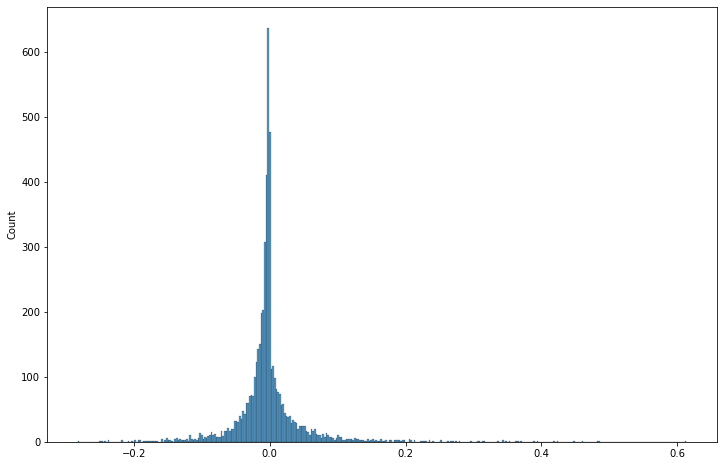

In [204]:
import seaborn as sns
x_train, y_train = synergies[:, :2], synergies[:, 2]
fig = plt.figure(figsize=(12, 8))
sns.histplot(y_train)